In [1]:
import pandas as pd ## pandas 라이브러리를 가져오기 위하여 import를 해줍니다.
import os
import matplotlib.pyplot as plt

# csv 형식으로 된 데이터 파일을 읽어옵니다.
df = pd.read_csv('df.csv')
              
# 데이터의 최상단 5 줄을 표시합니다.
df.shape

(822, 5)

In [2]:
df.set_index('DateTime',inplace = True)

In [3]:
df

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2018-09-09,281,266,73,1826
2018-09-10,264,247,51,2092
2018-09-11,329,310,58,1998
2018-09-12,300,287,45,2595
2018-09-13,378,344,50,3845
...,...,...,...,...
2020-12-04,3189,3068,743,75730
2020-12-05,2055,2019,497,47638
2020-12-06,2119,2077,460,46914


### 정상성 (Stationary time series) 확인

VAR을 적용시켜보기 전에 시계열 변수들이 모두 stationay 상태이어야 합니다.   
시계열 데이터가 일정한 평균과 분산을 나타내지 않으면 변수는 unstationay 상태입니다.   
AIC 기준을 사용하여 데이터의 stationarity를 찾기 위해 ADF(Advanced Dickey-Fuller test)와 같은 통계적 테스트를 수행해보겠습니다.

In [4]:
from statsmodels.tsa.stattools import adfuller

def pvalue(col, df):
    adfuller_test = adfuller(df[col], autolag= "AIC")
    print(col, "ADF test statistic: {}".format(adfuller_test[0]))
    print(col, "p-value: {}".format(adfuller_test[1]))

In [5]:
for i in df.columns[:]:
    pvalue(i, df)
    print("")

사용자 ADF test statistic: -0.6097050340416731
사용자 p-value: 0.8687739727060741

세션 ADF test statistic: -0.6625133950334622
세션 p-value: 0.8562219921273279

신규방문자 ADF test statistic: -0.9128235010313065
신규방문자 p-value: 0.783720126863696

페이지뷰 ADF test statistic: -0.9745132573213693
페이지뷰 p-value: 0.7624461485458697



모두 p-value가 0.05(5%) 보다 크므로 충분히 유의미한 값을 가지지 않아 귀무가설(null hypothesis : 시계열이 안정적이지 않다.)을 기각할 수 없고 

모든 시계열이 안정적이지 않다고 결론을 내릴 수 있습니다.

## differencing / 차분

두 시계열 데이터는 모두 stationary 상태가 아니기 때문에 차분을 취하고 나서 stationary를 확인해봅시다.

In [6]:
df_diff = df.diff().dropna()

In [7]:
for i in df_diff.columns[:]:
    pvalue(i, df_diff)
    print("")

사용자 ADF test statistic: -9.054672080328137
사용자 p-value: 4.736791422734554e-15

세션 ADF test statistic: -9.267893373277204
세션 p-value: 1.3513729779681978e-15

신규방문자 ADF test statistic: -10.360959909235712
신규방문자 p-value: 2.3972479821125685e-18

페이지뷰 ADF test statistic: -6.478444444199399
페이지뷰 p-value: 1.3132077538743404e-08



차분 결과, p-value 값이 모두 0.05보다 작으므로 모든 시계열이 안정적이게 되었다고 볼 수 있습니다.

### Modeling

In [8]:
train = df_diff.iloc[:-10,:]
test = df_diff.iloc[-10:,:]

grid-search를 수행해서 최적의 순서 p를 조사해보겠습니다.

In [9]:
from statsmodels.tsa.api import VAR

forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/home/ubuntu/anaconda3/envs/world/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


위 코드의 첫 번째 줄에서 VAR 모델을 학습시킵니다.

나머지 줄에서는 1부터 10까지 적합한 순서에 대한 AIC 점수를 찾기 위해 반복문을 통해 grid-search를 합니다.

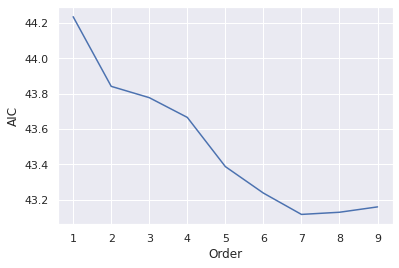

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

AIC는 주어진 데이터 셋에 대한 통계 모델의 상대적인 품질을 평가합니다.   
결과 그래프에서 AIC가 낮을 수록 모형의 적합도가 높으므로,   
가장 낮은 AIC 점수는 7이고    
그 이후 p가 커짐에 따라 증가 추세를 보입니다.
따라서 VAR모델의 최적 순서는 7로 선택합니다.
예측 모형에 순서 7로 fit 시키고 요약 결과를 살펴봅시다.

In [11]:
results = forecasting_model.fit(7)
#results.summary()

위에서 도출한 것처럼 VAR모델을 맞추는데 최적의 순서로 7을 사용합니다.

학습된 모델에 7일 동안의 훈련을 넣어 향후 10일 동안의 테스트 데이터를 예측해봅시다.

In [12]:
laaged_values = train.values[-7:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['사용자_1d', '세션_1d', '신규방문자_1d', '페이지뷰_1d'])
forecast

,사용자_1d,세션_1d,신규방문자_1d,페이지뷰_1d
DateTime,,,,
2020-11-29,-185.497756,-173.571059,-81.893277,-4737.289314
2020-11-30,1330.577736,1317.577201,348.175487,36346.568373
2020-12-01,291.519428,295.280970,102.931184,7829.073487
2020-12-02,-92.559798,-110.453361,-10.594575,-2791.108340
2020-12-03,-142.265395,-124.853105,-64.206409,-4739.224716
2020-12-04,-231.172721,-225.783253,-62.027470,-5617.297096
2020-12-05,-703.714143,-705.286858,-188.528100,-17969.578620
2020-12-06,-106.631367,-103.831092,-30.695347,-3365.198926
2020-12-07,860.413459,850.224620,226.260626,23358.501753


차분에 대한 모델입니다.

In [13]:
forecast["사용자_fc"] = df["사용자"].iloc[-10-1] + forecast['사용자_1d'].cumsum()
forecast["세션_fc"] = df["세션"].iloc[-10-1] + forecast['세션_1d'].cumsum() 
forecast["신규방문자_fc"] = df["신규방문자"].iloc[-10-1] + forecast['신규방문자_1d'].cumsum() 
forecast["페이지뷰_fc"] = df["페이지뷰"].iloc[-10-1] + forecast['페이지뷰_1d'].cumsum() 
forecast

,사용자_1d,세션_1d,신규방문자_1d,페이지뷰_1d,사용자_fc,세션_fc,신규방문자_fc,페이지뷰_fc
DateTime,,,,,,,,
2020-11-29,-185.497756,-173.571059,-81.893277,-4737.289314,2239.502244,2174.428941,536.106723,50320.710686
2020-11-30,1330.577736,1317.577201,348.175487,36346.568373,3570.079980,3492.006143,884.282211,86667.279059
2020-12-01,291.519428,295.280970,102.931184,7829.073487,3861.599408,3787.287112,987.213394,94496.352546
2020-12-02,-92.559798,-110.453361,-10.594575,-2791.108340,3769.039610,3676.833751,976.618820,91705.244205
2020-12-03,-142.265395,-124.853105,-64.206409,-4739.224716,3626.774215,3551.980646,912.412411,86966.019490
2020-12-04,-231.172721,-225.783253,-62.027470,-5617.297096,3395.601494,3326.197393,850.384941,81348.722394
2020-12-05,-703.714143,-705.286858,-188.528100,-17969.578620,2691.887351,2620.910535,661.856841,63379.143773
2020-12-06,-106.631367,-103.831092,-30.695347,-3365.198926,2585.255984,2517.079443,631.161494,60013.944848
2020-12-07,860.413459,850.224620,226.260626,23358.501753,3445.669442,3367.304063,857.422120,83372.446601


/tmp/ipykernel_2652/3790156391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["페이지뷰_fc"] = forecast["페이지뷰_fc"]


<AxesSubplot:xlabel='DateTime'>

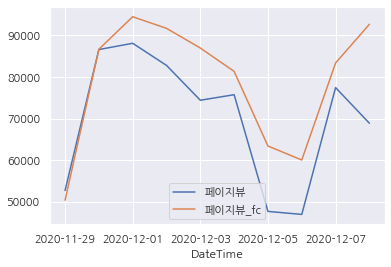

In [14]:
test = df.iloc[-10:,:]
test["페이지뷰_fc"] = forecast["페이지뷰_fc"]

plt.rc("font", family="NanumGothic") #폰트설정
plt.rc("axes", unicode_minus = False)
test[['페이지뷰',"페이지뷰_fc"]].plot()